In [98]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc, classification_report, precision_recall_curve
from sklearn.ensemble import GradientBoostingClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [99]:
# Read csv data file
df = pd.read_csv("../data/internet_service_churn.csv")

# drop user id
df.drop('id', axis=1, inplace=True)

print(df.shape)

# Data preview
print("\nhe first 5 rows of data:")
print(df.head())

(72274, 10)

he first 5 rows of data:
   is_tv_subscriber  is_movie_package_subscriber  subscription_age  bill_avg  \
0                 1                            0             11.95        25   
1                 0                            0              8.22         0   
2                 1                            0              8.91        16   
3                 0                            0              6.87        21   
4                 0                            0              6.39         0   

   reamining_contract  service_failure_count  download_avg  upload_avg  \
0                0.14                      0           8.4         2.3   
1                 NaN                      0           0.0         0.0   
2                0.00                      0          13.7         0.9   
3                 NaN                      1           0.0         0.0   
4                 NaN                      0           0.0         0.0   

   download_over_limit  churn  
0   

In [100]:
# Check if there are any variables with missing values
missing_values = df.isna().sum()
print("Number of missing values in each column:")
print(missing_values)

Number of missing values in each column:
is_tv_subscriber                   0
is_movie_package_subscriber        0
subscription_age                   0
bill_avg                           0
reamining_contract             21572
service_failure_count              0
download_avg                     381
upload_avg                       381
download_over_limit                0
churn                              0
dtype: int64


> # Data Exploration

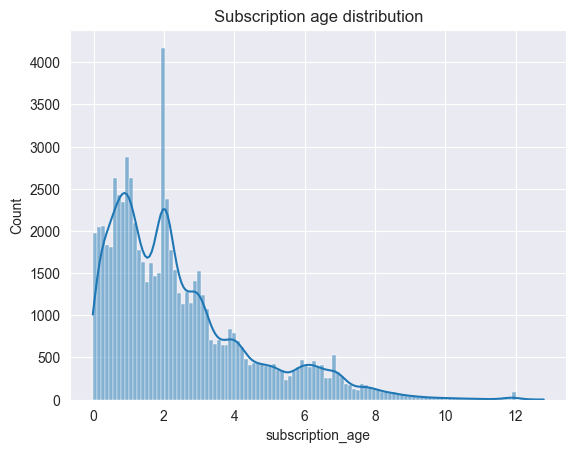

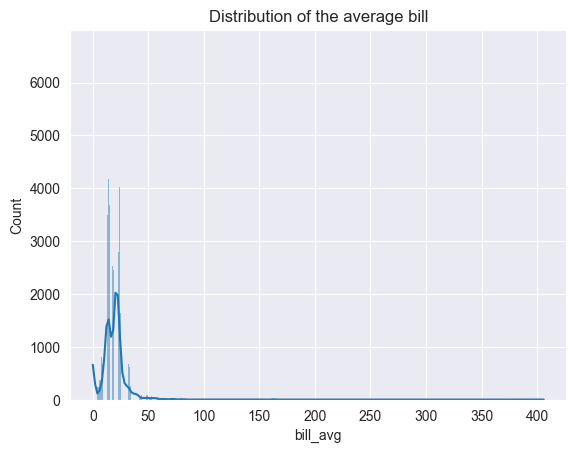

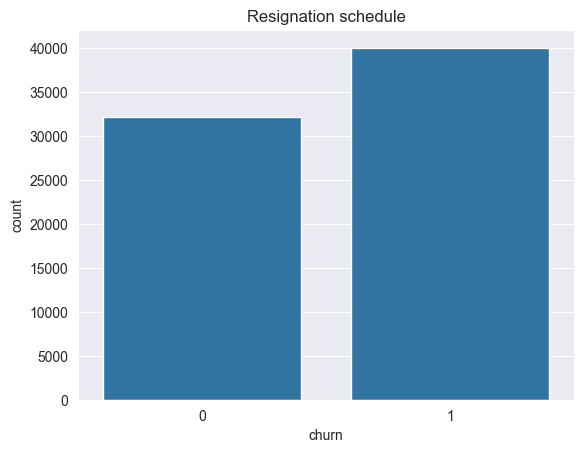

In [101]:
# Distribution of the 'subscription_age' variable_age'
sns.histplot(df['subscription_age'], kde=True)
plt.title('Subscription age distribution')
plt.show()

# Distribution of the 'bill_avg' variable
sns.histplot(df['bill_avg'], kde=True)
plt.title('Distribution of the average bill')
plt.show()

# Distribution of the 'churn' variable
sns.countplot(x='churn', data=df)
plt.title('Resignation schedule')
plt.show()

In [102]:
# NaN in 'reamining_contract' means no contract, so fill with 0
df.fillna({'reamining_contract': 0}, inplace=True)

# Or removing a column if it is not useful enough
# data.drop('reamining_contract', axis=1, inplace=True)
     
# NaN in the 'download_avg' and 'upload_avg' columns indicates inactivity, so fill with 0
df.fillna({'download_avg': 0}, inplace=True)
df.fillna({'upload_avg': 0}, inplace=True)

# Check if there are still NaNs in the columns
print(df.isna().sum())

is_tv_subscriber               0
is_movie_package_subscriber    0
subscription_age               0
bill_avg                       0
reamining_contract             0
service_failure_count          0
download_avg                   0
upload_avg                     0
download_over_limit            0
churn                          0
dtype: int64


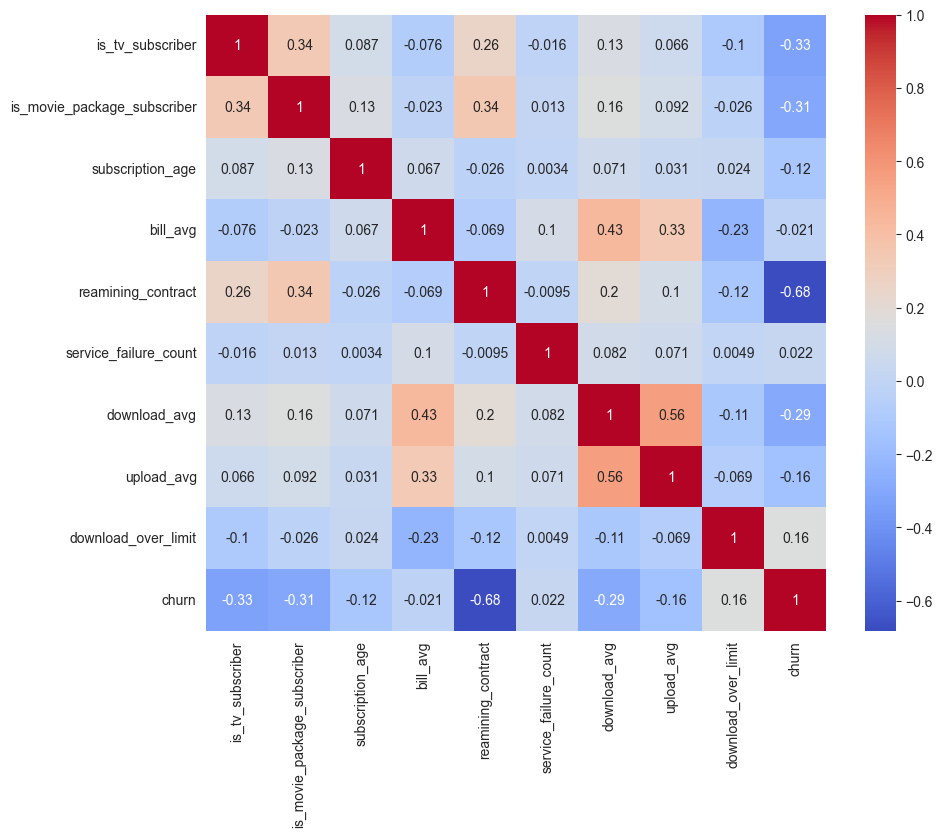

In [103]:
# Correlation matrix
corr = df.corr()

# Visualization of correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [104]:
# Selection of features for normalization
features_to_scale = ['subscription_age', 'bill_avg', 'reamining_contract', 'service_failure_count', 'download_avg', 'upload_avg']

# Feature normalization
scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
print(df.head())

   is_tv_subscriber  is_movie_package_subscriber  subscription_age  bill_avg  \
0                 1                            0          4.668335  0.458372   
1                 0                            0          2.835389 -1.433376   
2                 1                            0          3.174460 -0.222657   
3                 0                            0          2.171991  0.155692   
4                 0                            0          1.936116 -1.433376   

   reamining_contract  service_failure_count  download_avg  upload_avg  \
0           -0.541163              -0.335818     -0.553713   -0.190860   
1           -0.750269              -0.335818     -0.686378   -0.425611   
2           -0.750269              -0.335818     -0.470008   -0.333752   
3           -0.750269               0.888749     -0.686378   -0.425611   
4           -0.750269              -0.335818     -0.686378   -0.425611   

   download_over_limit  churn  
0                    0      0  
1         

In [105]:
# Splitting data into features (X) and target variable (y)
X = df.drop(columns=['churn'])
y = df['churn']

In [106]:
# # Support Vector Machine (SVM) Model with linear kernel
# svm_model = SVC(kernel='rbf', probability=True, random_state=42)

# Random Forest Model
rf_model = RandomForestClassifier(random_state=42)

# # Logistic Regression Model (simpler model for comparison)
# lr_model = LogisticRegression(random_state=42)

In [107]:
# # Perform Cross-Validation and print results
# def perform_cross_validation(model, X, y, cv=3):  # Reduced to 3 folds
#     print(f"Performing cross-validation for {model.__class__.__name__}...")
#     # Cross-validation for accuracy
#     accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
#     
#     print(f"Cross-Validation Results for {model.__class__.__name__}:")
#     print(f"Accuracy: {np.mean(accuracy):.2f} (+/- {np.std(accuracy):.2f})")
#     print("-" * 50)

In [108]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

In [109]:
# # Train the SVM model with linear kernel
# svm_model.fit(X_train, y_train)
# y_pred_svm = svm_model.predict(X_test)

In [110]:
# Train the Random Forest model
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [111]:
# # Train the Logistic Regression model
# lr_model.fit(X_train, y_train)
# y_pred_lr = lr_model.predict(X_test)

In [112]:
def evaluate_model(X_test, y_test, model):
    model_name = model.__class__.__name__
    y_pred = model.predict(X_test)
    print(f"Evaluating {model_name}...")
    # Calculating metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Displaying the results
    print(f"{model_name} Results:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"F1 Score: {f1:.2f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [113]:
# # Evaluate SVM Model
# evaluate_model(X_test, y_test, svm_model)

Evaluating RandomForestClassifier...
RandomForestClassifier Results:
Accuracy: 0.94
Recall: 0.94
Precision: 0.96
F1 Score: 0.95


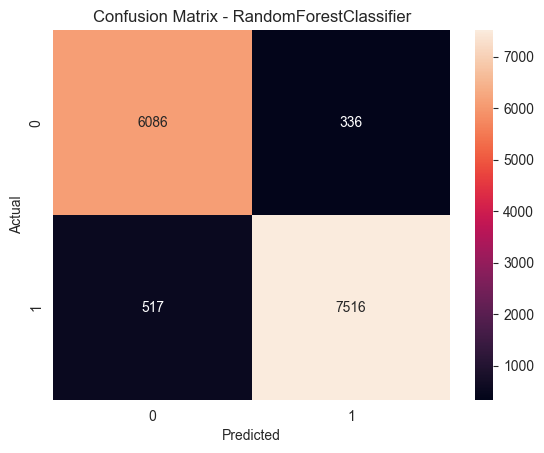

In [114]:
# Evaluate Random Forest Model
evaluate_model(X_test, y_test, rf_model)

In [115]:
# # Evaluate Logistic Regression Model
# evaluate_model(X_test, y_test, lr_model)

# Gradient Boosting

In [116]:
# # Define the Gradient Boosting model
# model_GB = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
# 
# # Train the model
# model_GB.fit(X_train, y_train)

In [117]:
# # Evaluate the model on the test set
# y_pred = model_GB.predict(X_test) 
# y_pred_prob = model_GB.predict_proba(X_test)[:, 1]
# 
# # Calculate evaluation metrics
# test_accuracy = model_GB.score(X_test, y_test)
# test_precision = precision_score(y_test, y_pred)
# test_recall = recall_score(y_test, y_pred)
# test_f1 = f1_score(y_test, y_pred)
# 
# print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
# print(f"Test Precision: {test_precision * 100:.2f}%")
# print(f"Test Recall: {test_recall * 100:.2f}%")
# print(f"Test F1 Score: {test_f1 * 100:.2f}%")
# 
# # Print full classification report
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred, digits=4))

In [118]:
# # Plot the ROC curve
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# roc_auc = auc(fpr, tpr)
# 
# # Plot the Precision-Recall curve
# precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
# 
# plt.figure(figsize=(16, 5))
# 
# # Subplot: ROC Curve
# plt.subplot(1, 2, 1)
# plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
# plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend(loc='lower right')

In [119]:
# plt.figure(figsize=(12.5, 5))
# plt.subplot(1, 2, 2)
# plt.plot(recall, precision, color='blue', lw=2)
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# 
# plt.tight_layout()
# plt.show()


# Dense Neural Net

In [120]:
features_num = X_train.shape[1]

In [121]:
# 5. Building the Neural Network

NN_model = Sequential([
    Input(shape=(features_num,)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
NN_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Set up EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [122]:
# 6. Training the Model

print("Training the model...")
history = NN_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Training the model...
Epoch 1/50
723/723 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7991 - loss: 0.4576 - val_accuracy: 0.8898 - val_loss: 0.2970
Epoch 2/50
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8872 - loss: 0.3229 - val_accuracy: 0.8979 - val_loss: 0.2795
Epoch 3/50
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8982 - loss: 0.2993 - val_accuracy: 0.9067 - val_loss: 0.2673
Epoch 4/50
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9049 - loss: 0.2889 - val_accuracy: 0.9073 - val_loss: 0.2646
Epoch 5/50
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9058 - loss: 0.2843 - val_accuracy: 0.9139 - val_loss: 0.2555
Epoch 6/50
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9104 - loss: 0.2746 - val_accuracy: 0.9152 - val_loss: 0.2532
Epoch 7/50
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9154 - loss: 0.2644 - val_accuracy: 0.9193 - val_loss: 0.2475
Epoch 8/50
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9168 - loss: 0.2

In [123]:
test_loss, test_acc = NN_model.evaluate(X_test,  y_test, verbose=2)
print('\nTest accuracy NN:', test_acc)

452/452 - 0s - 599us/step - accuracy: 0.9281 - loss: 0.2252

Test accuracy NN: 0.9281217455863953


In [124]:
# 7. Evaluating the Model

print("Evaluating the model...")
y_pred_train = NN_model.predict(X_train)
y_pred_test = NN_model.predict(X_test)

# Convert probabilities to binary predictions
y_pred_train = (y_pred_train > 0.5).astype(int)
y_pred_test = (y_pred_test > 0.5).astype(int)

def evaluate_model(y_true, y_pred, dataset_type="Test"):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"{dataset_type} Set Evaluation:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"F1 Score: {f1:.2f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix - {dataset_type} Set')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Evaluating the model...
1807/1807 ━━━━━━━━━━━━━━━━━━━━ 1s 659us/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step


Training Set Evaluation:
Accuracy: 0.93
Recall: 0.93
Precision: 0.94
F1 Score: 0.93


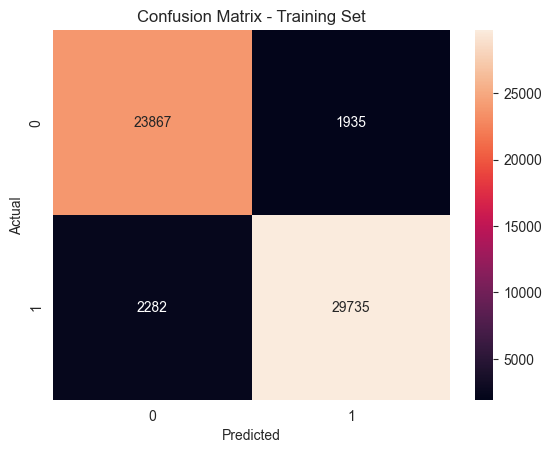

Test Set Evaluation:
Accuracy: 0.93
Recall: 0.93
Precision: 0.94
F1 Score: 0.93


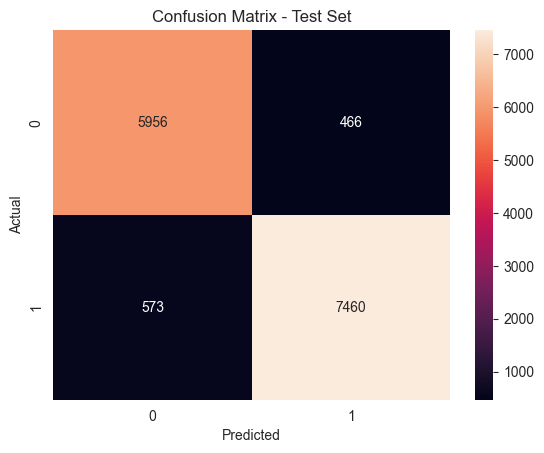

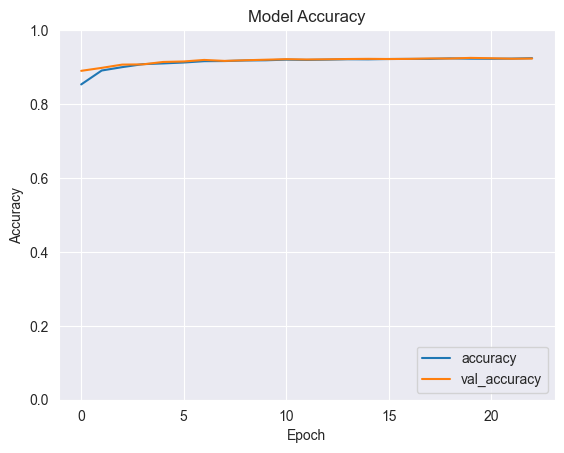

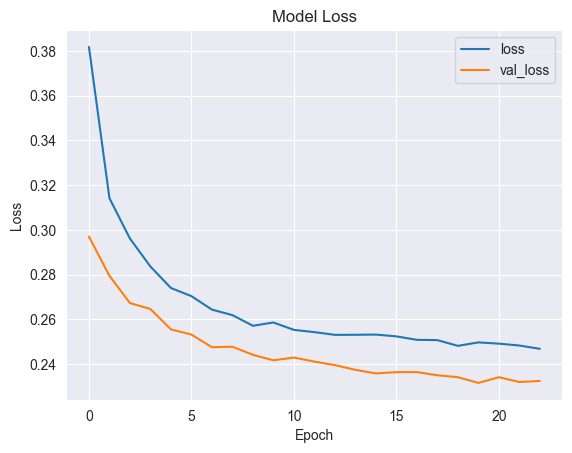

In [125]:
# Evaluate on training set
evaluate_model(y_train, y_pred_train, "Training")

# Evaluate on test set
evaluate_model(y_test, y_pred_test)

# 8. Plotting Training History

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.show()

In [126]:
# Zapisuje modele 
joblib.dump(rf_model, 'random_forest_model.pkl')
NN_model.save('dense_nn_model.keras')

In [127]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']